In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [54]:
df = pd.read_csv('transfer_learn_data.csv')
df2 = pd.read_csv('transfer_learn_data_new.csv')
df_union = pd.concat([df, df2])

In [55]:
df_union.shape

(4104, 4)

Train test split

In [61]:
# X_train, X_test, y_train, y_test = train_test_split(df_union[['predicted_label','scores']], df_union[['true_label']], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_union[['predicted_label','scores']], df_union['true_label'], test_size=0.2, random_state=42)

SMOTE

In [63]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train[['predicted_label','scores']], y_train)

In [81]:
len(y_res)

8133

# Building Models

In [6]:
Model_names = []
Models = []
Params = []

LR = LogisticRegression()
LR_parameters = {'penalty':('l1', 'l2', 'elasticnet', 'None'), 'C':np.arange(0,10)}
Models.append(LR)
Params.append(LR_parameters)
Model_names.append('Logistic Regression Classifier')

RF = RandomForestClassifier()
RF_parameters = {'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':np.arange(0,6), 'n_estimators':np.arange(30,50)}
Models.append(RF)
Params.append(RF_parameters)
Model_names.append('Random Forest Classifier')

DTC = tree.DecisionTreeClassifier()
DTC_parameters = {'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':np.arange(0,5)}
Models.append(DTC)
Params.append(DTC_parameters)
Model_names.append('Decision Tree Classifier')

In [192]:
import json
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

best_params = []

for count,model in enumerate(Models):
    print('current moedel: '+Model_names[count])
    clf = GridSearchCV(model, Params[count])
    clf.fit(X_train,y_train)
    best_params.append(clf.best_params_)
    print(clf.best_params_)

current moedel: Logistic Regression Classifier
{'C': 1, 'penalty': 'l2'}
current moedel: Random Forest Classifier
{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 41}
current moedel: Decision Tree Classifier
{'criterion': 'gini', 'max_depth': 3}


# Predictions and visualizations

In [193]:
Predictions = []

for count, model in enumerate(Models):
    print('current moedel: '+Model_names[count])
    model.set_params(**best_params[count])
    res = model.fit(X_train,y_train)
    y_predicted = res.predict(X_test)
    
    Predictions.append(y_predicted)

current moedel: Logistic Regression Classifier
current moedel: Random Forest Classifier
current moedel: Decision Tree Classifier


current moedel: Logistic Regression Classifier
              precision    recall  f1-score   support

       Liked       0.76      0.86      0.81        80
     neutral       0.41      0.14      0.21        51
   not liked       0.95      0.98      0.97       690

    accuracy                           0.92       821
   macro avg       0.71      0.66      0.66       821
weighted avg       0.90      0.92      0.90       821

current moedel: Random Forest Classifier
              precision    recall  f1-score   support

       Liked       0.76      0.86      0.81        80
     neutral       0.00      0.00      0.00        51
   not liked       0.94      0.99      0.96       690

    accuracy                           0.92       821
   macro avg       0.57      0.62      0.59       821
weighted avg       0.86      0.92      0.89       821

current moedel: Decision Tree Classifier
              precision    recall  f1-score   support

       Liked       0.74      0.86      0.80        80


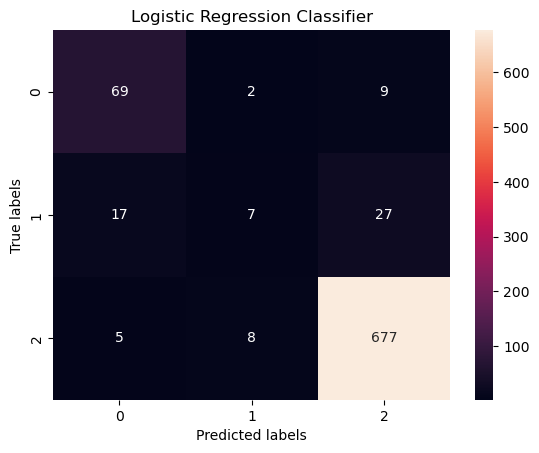

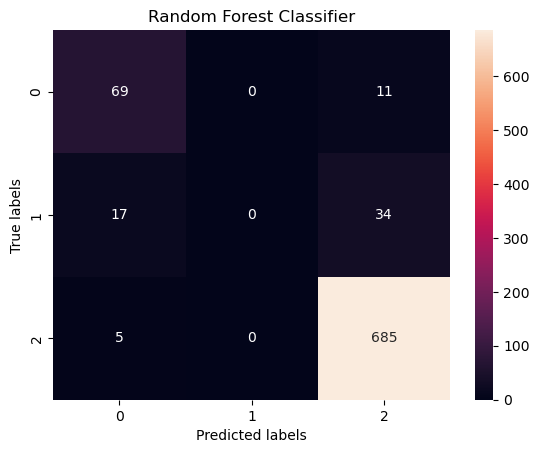

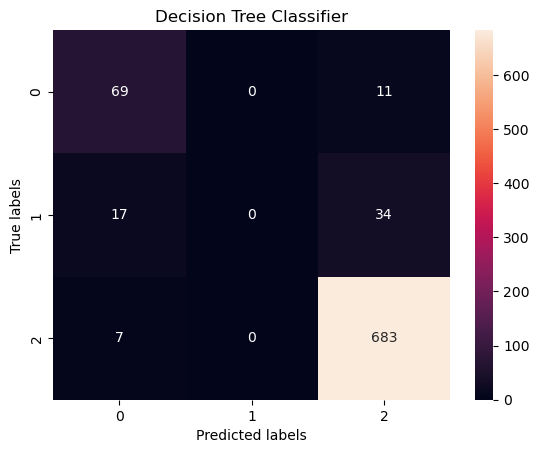

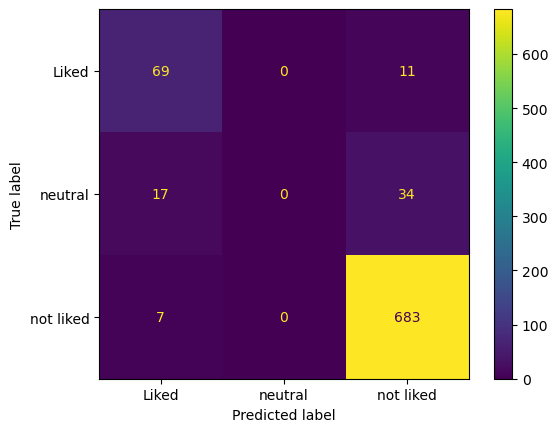

In [194]:
for count,prediction in enumerate(Predictions):
    print('current moedel: '+Model_names[count])
    target_names = ['Liked','neutral','not liked']

    cm = confusion_matrix(y_test, prediction)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(Model_names[count])

    cm_display = ConfusionMatrixDisplay(cm, display_labels=target_names).plot()

    print(classification_report(y_test, prediction, target_names=target_names))

CatBoost

In [64]:
from catboost import CatBoostClassifier, Pool

In [65]:
y_train_dum =  pd.get_dummies(y_res)
y_test_dum = pd.get_dummies(y_test)
y_test_dum = y_test_dum.rename(columns={-1: "negative", 0: "neutral", 1:'positive'})
y_train_dum = y_train_dum.rename(columns={-1: "negative", 0: "neutral", 1:'positive'})
# y_train_dum.drop('neutral',axis=1,inplace=True)
# y_test_dum.drop('neutral',axis=1,inplace=True)

In [66]:
train_pool = Pool(X_res, y_train_dum)
test_pool = Pool(X_test, y_test_dum)

In [80]:
clf = CatBoostClassifier(
    loss_function='MultiLogloss',
    eval_metric='Accuracy',
    iterations=150,
    class_names=['negative','neutral', 'positive'],
    learning_rate=0.03
)
clf.fit(train_pool, eval_set=test_pool, metric_period=10, plot=True, verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7233493	test: 0.8197320	best: 0.8197320 (0)	total: 3.29ms	remaining: 490ms
50:	learn: 0.6950695	test: 0.8099878	best: 0.8197320 (0)	total: 142ms	remaining: 276ms
100:	learn: 0.7030616	test: 0.8099878	best: 0.8197320 (0)	total: 272ms	remaining: 132ms
149:	learn: 0.7047830	test: 0.8002436	best: 0.8197320 (0)	total: 354ms	remaining: 0us

bestTest = 0.8197320341
bestIteration = 0

Shrink model to first 1 iterations.


In [72]:
data = clf.predict(X_test)

In [73]:
dataset = pd.DataFrame({'negative': data[:, 0], 'neutral': data[:, 1], 'positive': data[:, 1]})

In [74]:
len(data)

821

In [75]:
dic = {'col':[]}
for index,row in dataset.iterrows():
        if row['positive'] == 1:
                dic['col'].append(1)
        elif row['negative'] == 1:
                dic['col'].append(-1)
        elif row['neutral'] == 0:
                dic['col'].append(0)
        elif row['negative']==0 and row['positive'] == 0 and row['neutral'] == 0:
                print('both  0')
        else:
                print('wrong')

In [76]:
result_frame = pd.DataFrame.from_dict(dic)

In [77]:
print(classification_report(y_test, result_frame))

              precision    recall  f1-score   support

          -1       0.76      0.86      0.81        80
           0       0.02      0.18      0.03        51
           1       0.75      0.15      0.26       690

    accuracy                           0.22       821
   macro avg       0.51      0.40      0.36       821
weighted avg       0.71      0.22      0.29       821

